**`recommendation system`**

The goal of this notebook is to apply collaborative filtering on a restaurant dataset with customer ratings. Collaborative filtering allows us to create recommendation systems based on what activity a user has taken. Recommendation systems are around us on our faviourite services, like facebook,etc...

In this case we will be using the Fast.ai library which will implement probalisitic matrix factorization. We will just use two factorized matrices as embedding matrices that can be modeled by addding an embedding layer in the neural net.


In [ ]:
import pandas as pd
import numpy as np
import plotly.express as px
import matplotlib.pyplot as plt
import seaborn as sns
import fastai as fs
from sklearn.decomposition import PCA
%matplotlib inline
plt.rcParams['font.size'] = 12
plt.rcParams['figure.figsize'] = (15, 10)

#supress warnings
import warnings

warnings.filterwarnings("ignore")
warnings.filterwarnings("ignore", category=DeprecationWarning)
warnings.filterwarnings("ignore", category=UserWarning)
warnings.filterwarnings("ignore", category=FutureWarning)
import re
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.metrics.pairwise import cosine_similarity


In [ ]:
from google.colab import files
uploaded = files.upload()



Saving consumer_preferences.csv to consumer_preferences.csv
Saving consumers.csv to consumers.csv
Saving ratings.csv to ratings.csv
Saving restaurant_cuisines.csv to restaurant_cuisines.csv
Saving restaurants.csv to restaurants.csv


EDA

In [ ]:
Ratings = pd.read_csv('ratings.csv')
Ratings.head()


,Consumer_ID,Restaurant_ID,Overall_Rating,Food_Rating,Service_Rating
0,U1077,135085,2,2,2
1,U1077,135038,2,2,1
2,U1077,132825,2,2,2
3,U1077,135060,1,2,2
4,U1068,135104,1,1,2


Text(0.5, 1.0, 'Count of ratings given')

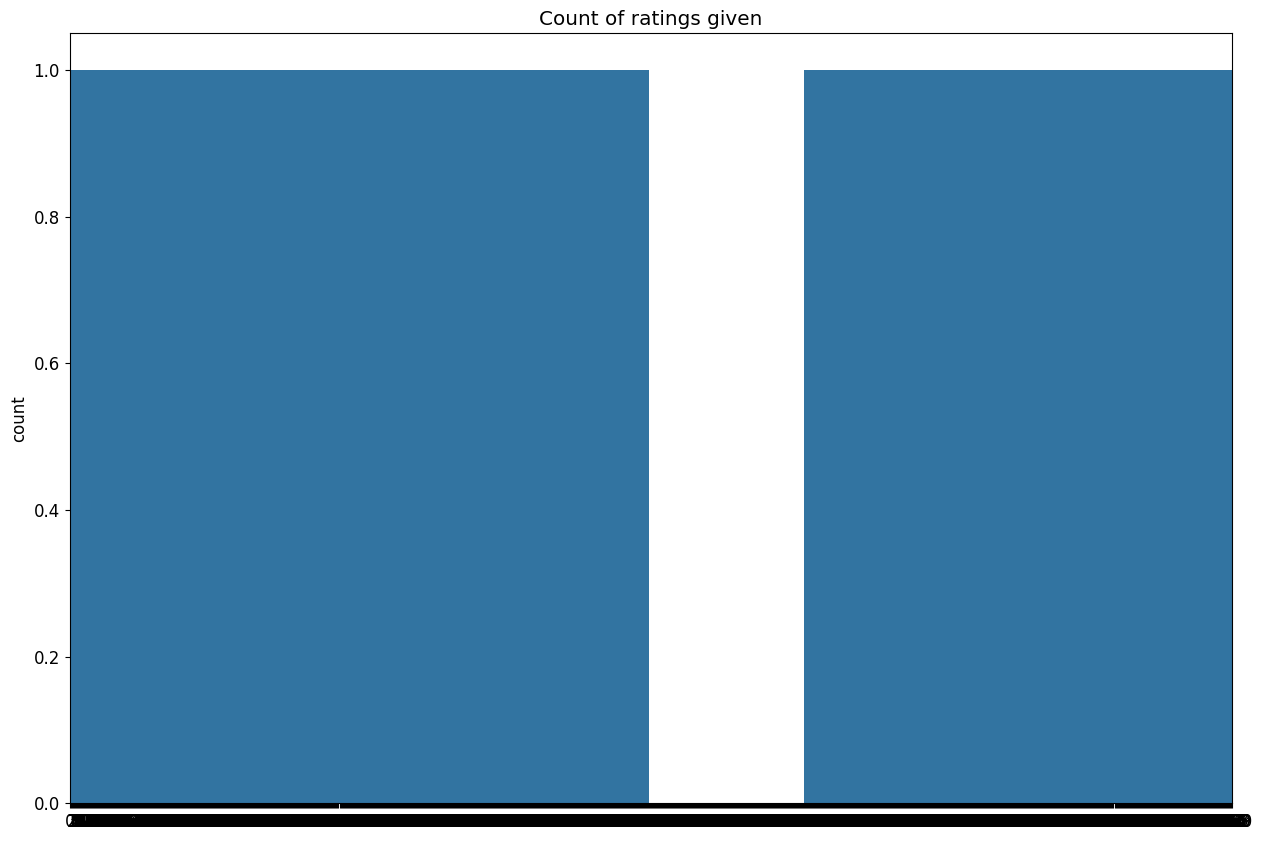

In [ ]:
df = Ratings['Overall_Rating']
sns.countplot(df)
plt.title('Count of ratings given')

In [ ]:



# Load the data
places = pd.read_csv('restaurants.csv')

# Display only the Latitude and Longitude columns
places_lat_long = places[['Latitude', 'Longitude']]

# Show the result
print(places_lat_long.head())

    Latitude   Longitude
0  23.752304  -99.166913
1  23.726819  -99.126506
2  23.730925  -99.145185
3  22.141647 -100.992712
4  18.922290  -99.234332


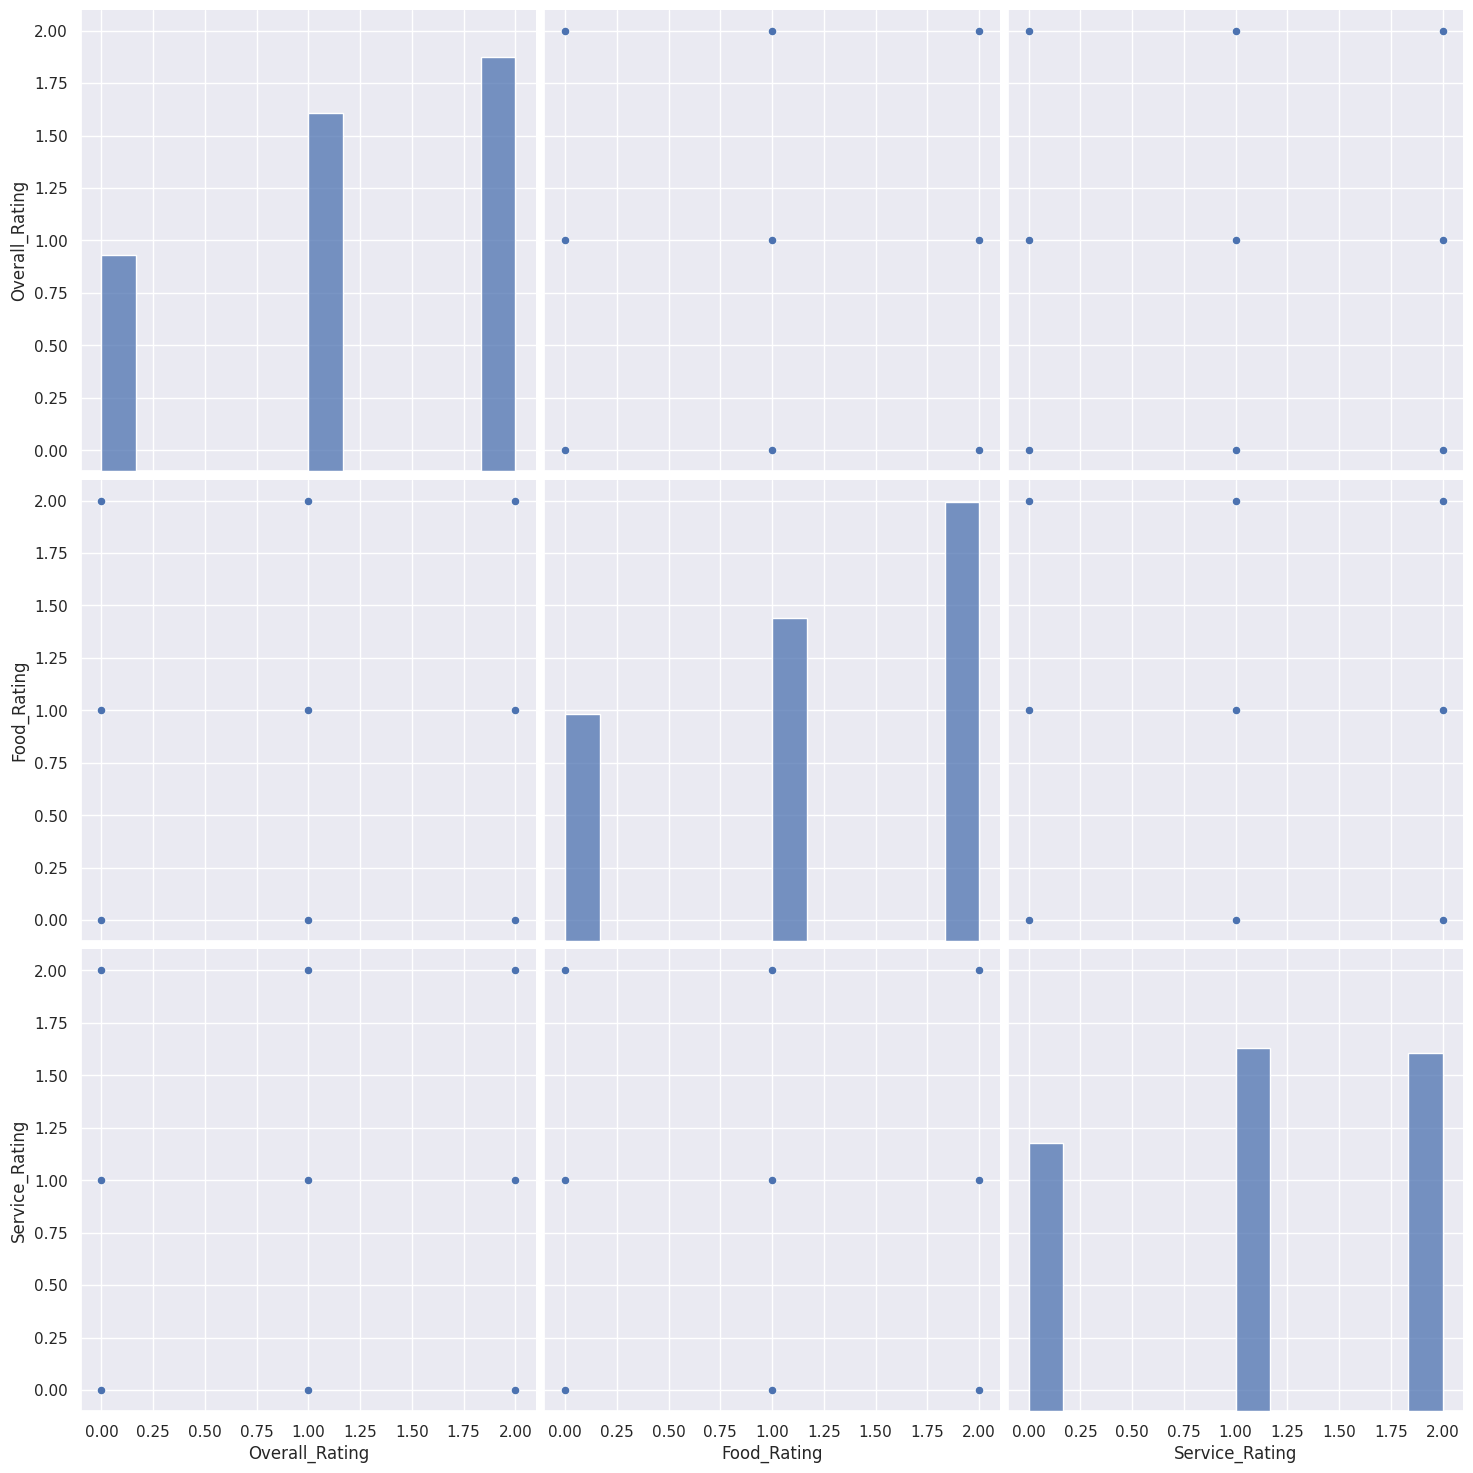

In [ ]:
sns.set()
columns = ['Overall_Rating', 'Food_Rating','Service_Rating']
sns.pairplot(Ratings[columns],height=5,kind='scatter')
plt.show()
#From my observations the three variables rating, food_rating and service_rating have a relationship that is weird. If the value of rating is 0 the user gave service_rating that was 0 too. the relationship is the same with all the other variables too.

<Axes: >

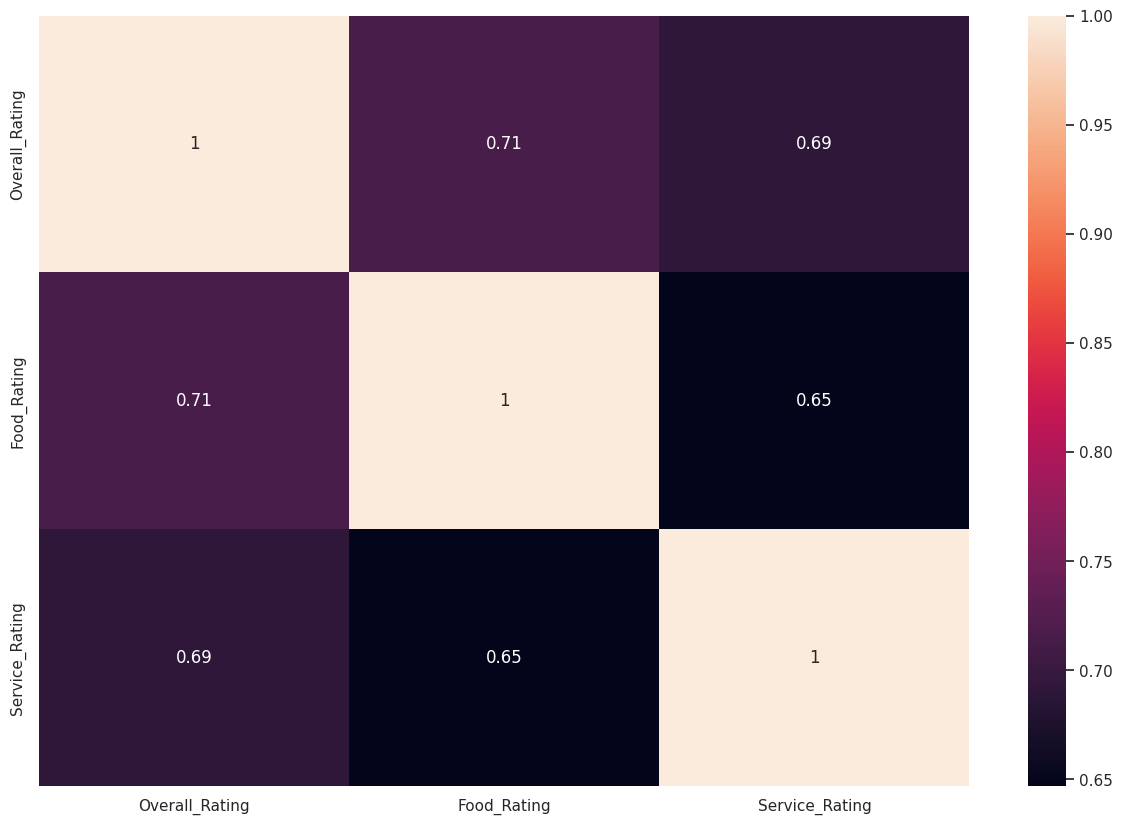

In [ ]:
fig = (
   Ratings.loc[:,['Overall_Rating', 'Food_Rating','Service_Rating']]
).corr()

sns.heatmap(fig, annot=True)
#However it appears that all the variables in the ratings dataframe have a strong positive relantionship with each other.

In [ ]:
len(Ratings['Consumer_ID'].unique())
len(Ratings['Restaurant_ID'].unique())
#We have about 130 different restaurants in the dataset.
#While there appears to 138 different users who gave reviews

130

<Axes: title={'center': 'Users with the most reviews '}, xlabel='Consumer_ID'>

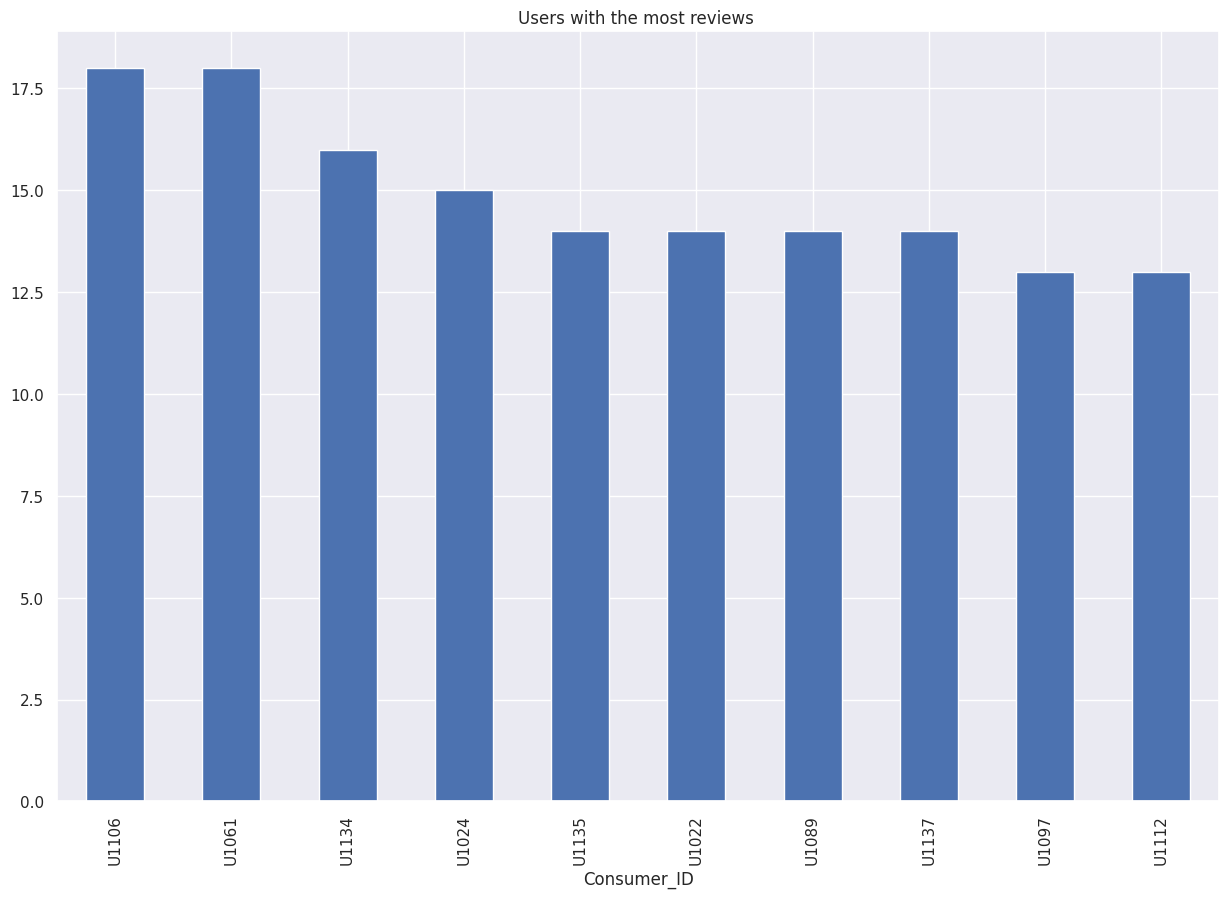

In [ ]:
Ratings['Consumer_ID'].value_counts().head(10).plot.bar( title='Users with the most reviews ')


<Axes: title={'center': 'Places with most reviews'}, xlabel='Restaurant_ID'>

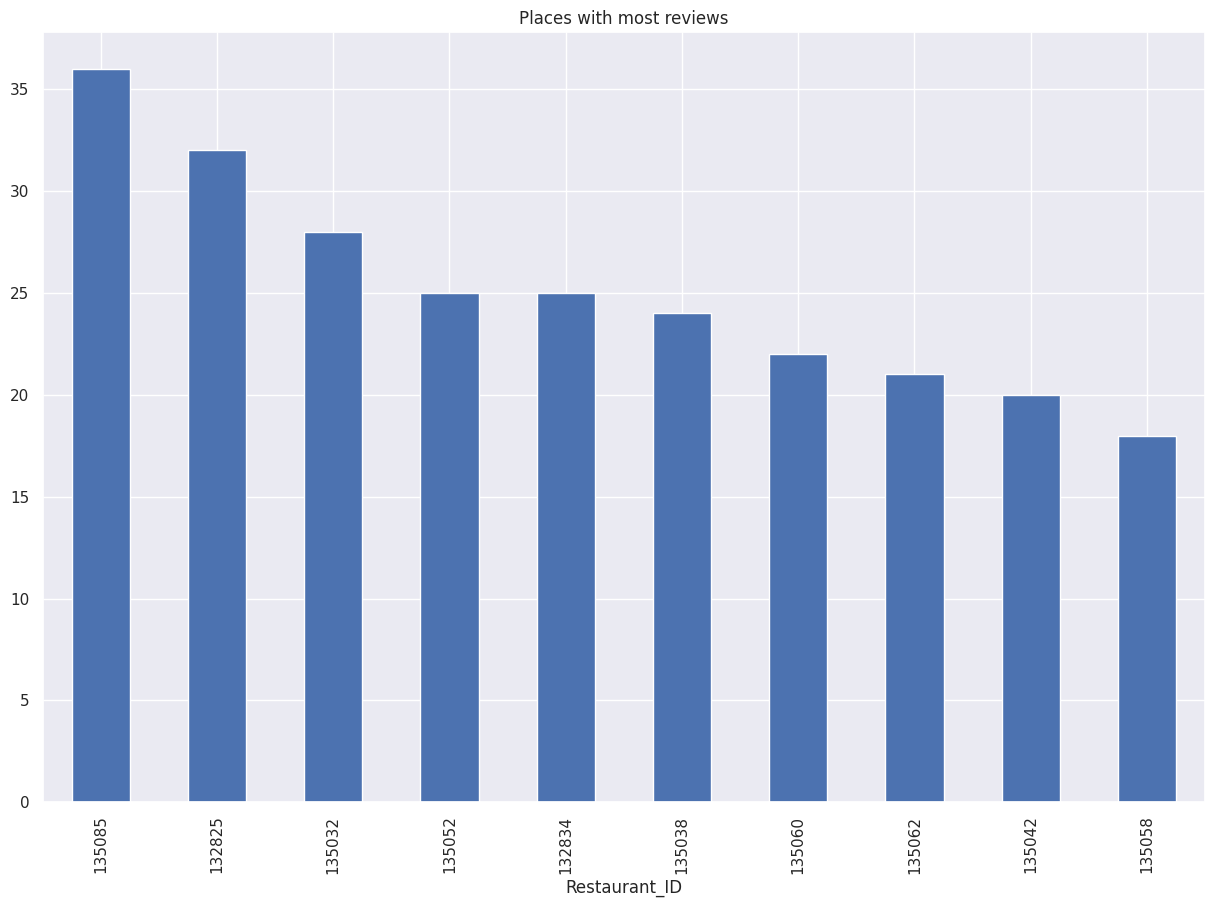

In [ ]:
Ratings['Restaurant_ID'].value_counts().head(10).plot.bar(title='Places with most reviews')

In [ ]:
mean = Ratings['Restaurant_ID'].value_counts().mean()
mean
#The Top Restaurant has about 35 reviews
#Each restaurant has an average of about 8 ratings.

8.930769230769231

<Axes: xlabel='Restaurant_ID', ylabel='Overall_Rating'>

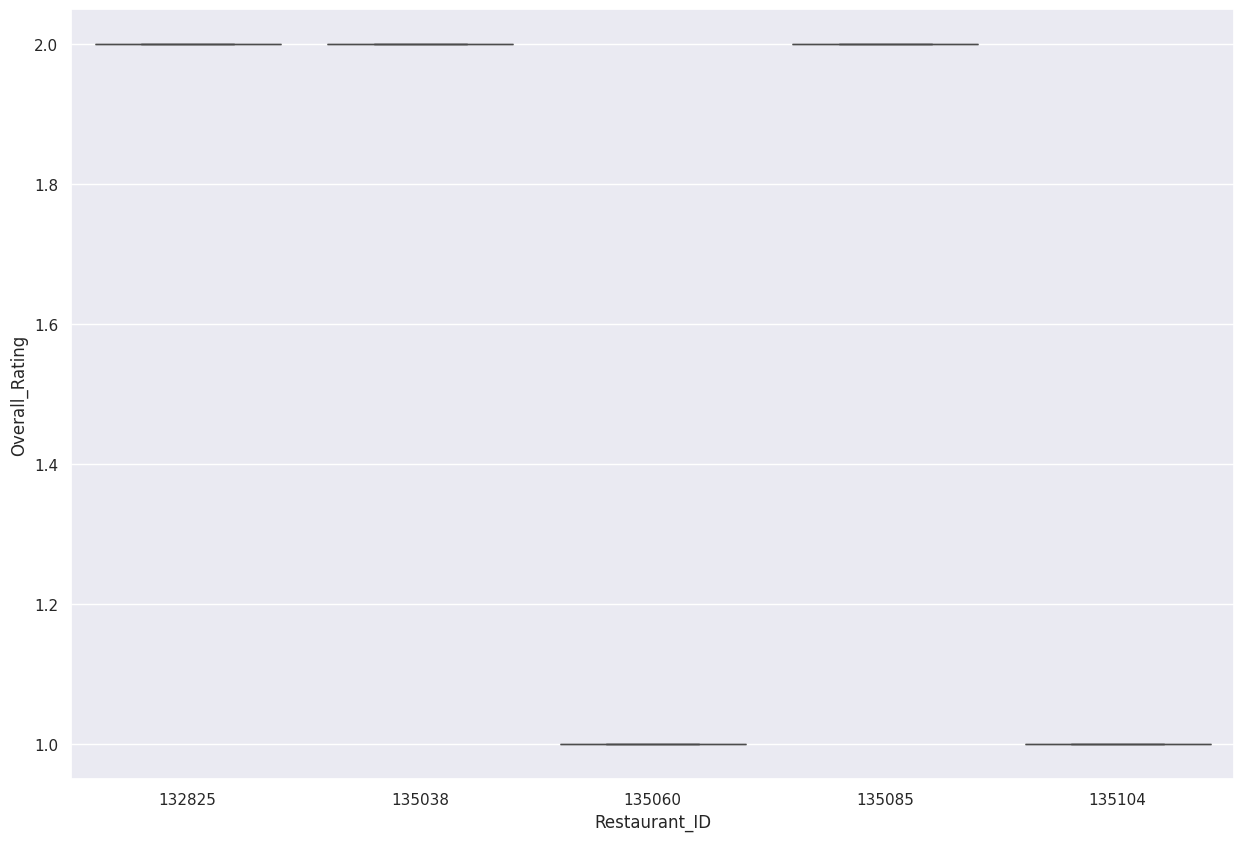

In [ ]:
sns.boxplot(
   x='Restaurant_ID',
    y='Overall_Rating',
    data=Ratings.head(5)


 )

In [ ]:
Ratings.isnull().any()


,0
Consumer_ID,False
Restaurant_ID,False
Overall_Rating,False
Food_Rating,False
Service_Rating,False


In [ ]:
places.isnull().any()

,0
Restaurant_ID,False
Name,False
City,False
State,False
Country,False
Zip_Code,True
Latitude,False
Longitude,False
Alcohol_Service,True
Smoking_Allowed,False


**Create Model**

In [ ]:
from fastai.learner import *
from sklearn.decomposition import PCA
from plotnine import *

from fastai.collab import *
from fastai.tabular.all import *
import torch.optim as optim






In [ ]:
import numpy as np

# Set the random seed for reproducibility
np.random.seed(42)

# Create an array of indices
indices = np.arange(len(Ratings))
np.random.shuffle(indices)

# Set the proportion of the dataset to include in the validation split
val_size = int(len(Ratings) * 0.2)  # 20% for validation
val_idxs = indices[:val_size]  # Validation indices
train_idxs = indices[val_size:]  # Training indices

# Now you can use train_idxs and val_idxs for your model training
wd = 2e-4
n_factors = 50


epoch,train_loss,valid_loss,time
0,2.048628,2.262929,00:00
1,2.044723,2.259438,00:00
2,2.019567,2.256546,00:00
3,1.967263,2.255127,00:00
4,1.947905,2.254883,00:00


Validation Loss: [2.2548828125]


epoch,train_loss,valid_loss,time
0,1.858780,2.253472,00:00
1,1.983584,2.249720,00:00
2,1.971510,2.246808,00:00
3,1.973488,2.245402,00:00
4,1.970284,2.245159,00:00


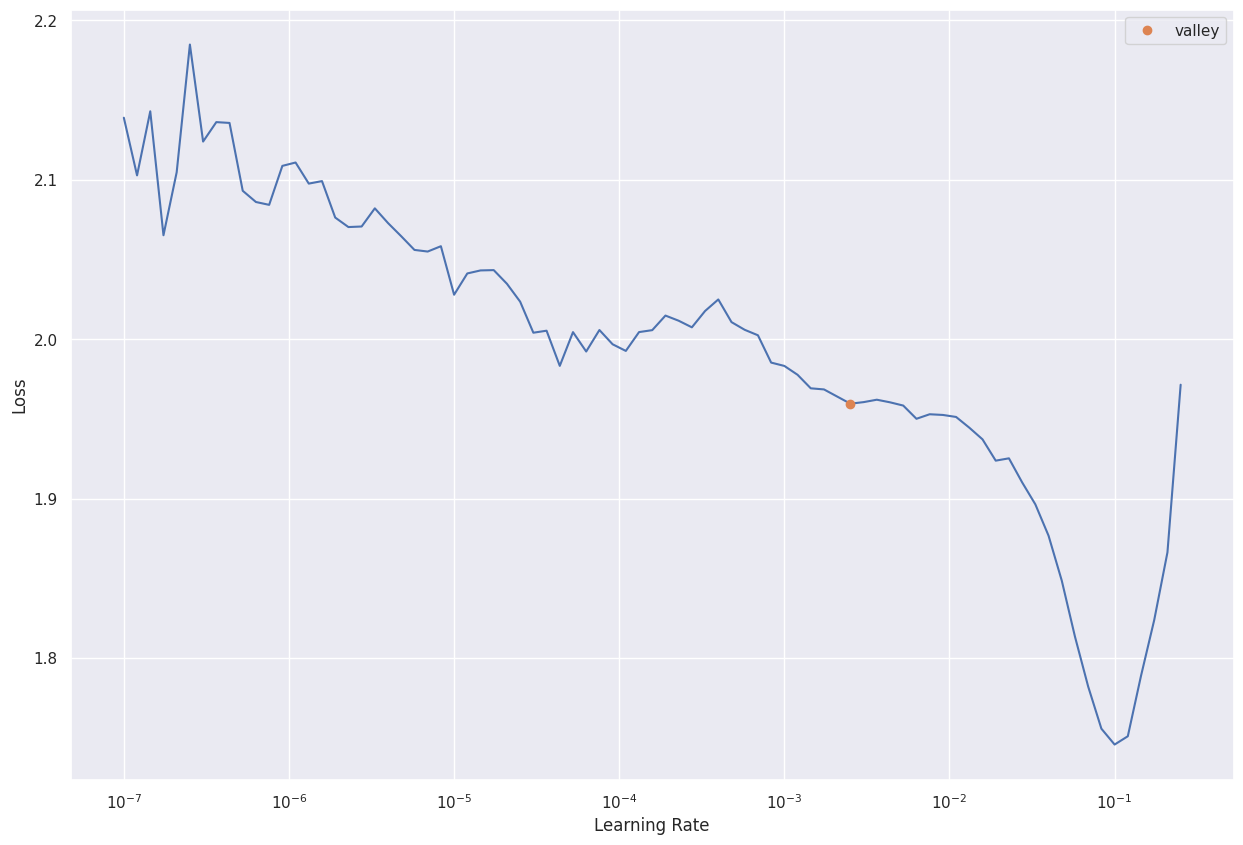

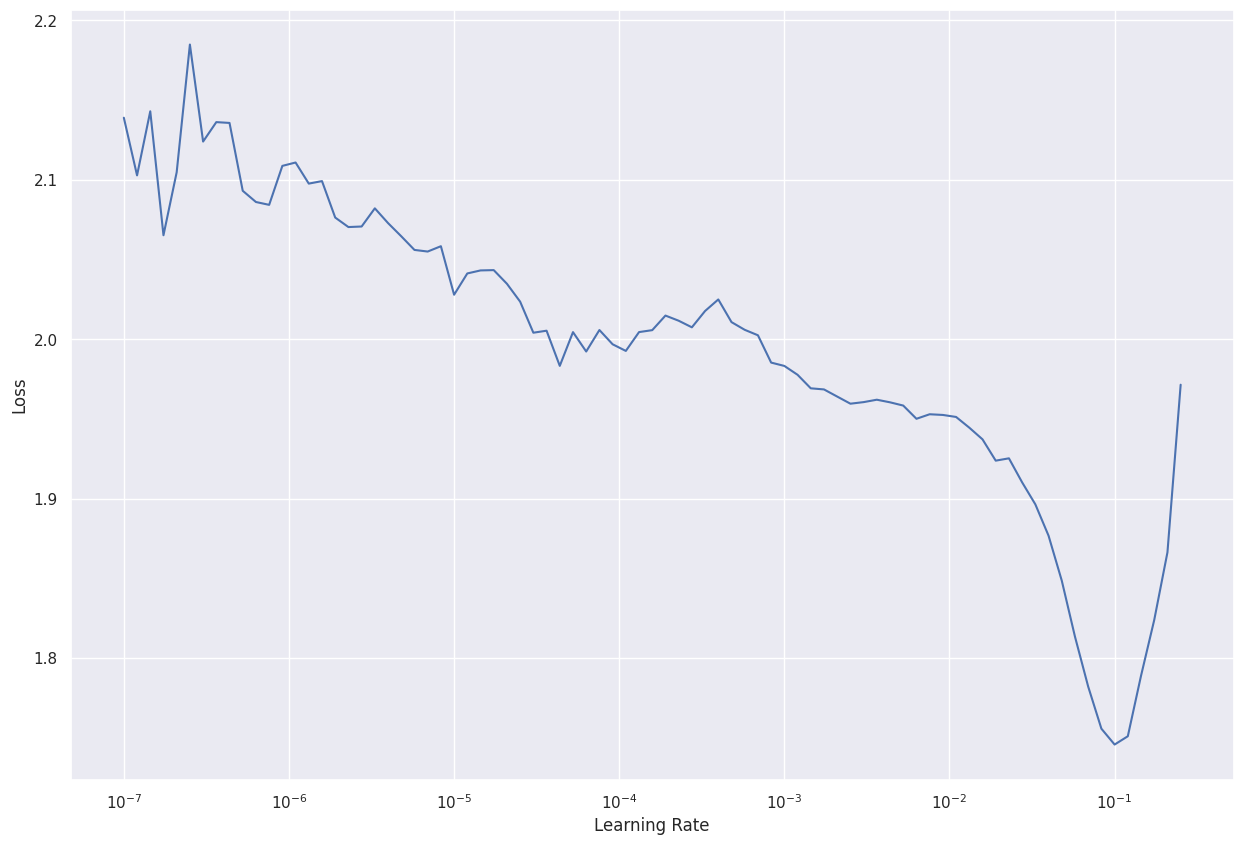

In [ ]:
dls = CollabDataLoaders.from_df(Ratings, user_name='Consumer_ID', item_name='Restaurant_ID', rating_name='Overall_Rating', valid_pct=0.2)
# Set parameters
n_factors = 50
wd = 2e-4

# Create a learner
learn = collab_learner(dls, n_factors=n_factors, wd=wd)

# Find optimal learning rate
learn.lr_find()
learn.recorder.plot_lr_find()

# Train model using optimal learning rate found
learn.fit_one_cycle(5, slice(1e-3, 1e-4))

# Validate the model
val_loss = learn.validate()
print(f'Validation Loss: {val_loss}')

# Implementing early stopping based on validation loss
learn.fit_one_cycle(5, slice(1e-3, 1e-4), cbs=[EarlyStoppingCallback(patience=2)])





**Analysis of results**

In [ ]:
µrestaurant_names = places.set_index('Restaurant_ID')['Name'].to_dict()
g=Ratings.groupby('Restaurant_ID')['Overall_Rating'].count()
topRestaurants = g.sort_values(ascending=False).index.values[:3000]
# Create a mapping of Restaurant_ID to index
restaurant_ids = Ratings['Restaurant_ID'].unique()
restaurant_to_idx = {restaurant_id: idx for idx, restaurant_id in enumerate(restaurant_ids)}

# Now you can get the indices of the top restaurants
topRestIdx = np.array([restaurant_to_idx[o] for o in topRestaurants if o in restaurant_to_idx])
print(Ratings.head())
print(Ratings.info())





  Consumer_ID  Restaurant_ID  Overall_Rating  Food_Rating  Service_Rating
0       U1077         135085               2            2               2
1       U1077         135038               2            2               1
2       U1077         132825               2            2               2
3       U1077         135060               1            2               2
4       U1068         135104               1            1               2
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1161 entries, 0 to 1160
Data columns (total 5 columns):
 #   Column          Non-Null Count  Dtype 
---  ------          --------------  ----- 
 0   Consumer_ID     1161 non-null   object
 1   Restaurant_ID   1161 non-null   int64 
 2   Overall_Rating  1161 non-null   int64 
 3   Food_Rating     1161 non-null   int64 
 4   Service_Rating  1161 non-null   int64 
dtypes: int64(4), object(1)
memory usage: 45.5+ KB
None


In [ ]:
import torch
print(torch.cuda.is_available())



True


In [ ]:
m=learn.model; m.cuda()

EmbeddingDotBias(
  (u_weight): Embedding(139, 50)
  (i_weight): Embedding(131, 50)
  (u_bias): Embedding(139, 1)
  (i_bias): Embedding(131, 1)
)

In [ ]:
topRestIdx_tensor = torch.tensor(topRestIdx).cuda()
# Retrieve item biases using the appropriate attribute
restaurant_bias = to_np(m.i_bias(topRestIdx_tensor))  # Use i_bias to get item biases


print(restaurant_bias)


[[-2.72931810e-03]
 [ 1.15385605e-02]
 [ 1.79201236e-03]
 [-2.67348648e-03]
 [ 4.28489922e-03]
 [-2.71259132e-03]
 [-1.40100217e-03]
 [ 2.32539815e-03]
 [ 1.16426153e-02]
 [ 3.05521768e-03]
 [ 1.02408910e-02]
 [ 8.12838320e-03]
 [ 6.75102556e-03]
 [ 1.40410587e-02]
 [ 6.99304603e-03]
 [-1.05074793e-03]
 [-1.27197504e-02]
 [ 2.10259855e-02]
 [-3.00004007e-03]
 [ 1.45648912e-04]
 [ 3.61564278e-04]
 [ 1.03119994e-02]
 [-9.56435595e-03]
 [ 2.77676783e-03]
 [ 1.15194824e-02]
 [ 9.21442639e-03]
 [ 5.51843457e-03]
 [ 3.25672678e-04]
 [-9.92469490e-03]
 [ 1.28017657e-03]
 [ 8.92499404e-04]
 [-1.54270616e-04]
 [-8.29264987e-04]
 [ 5.30677848e-03]
 [ 6.94038181e-06]
 [ 2.38144747e-03]
 [ 1.37046464e-02]
 [-9.04071424e-03]
 [ 3.90195707e-03]
 [ 1.41627574e-02]
 [ 1.78217422e-02]
 [ 8.54346994e-03]
 [ 6.67421333e-03]
 [-1.21366011e-03]
 [ 8.68709385e-03]
 [ 1.53851369e-03]
 [ 7.46221095e-03]
 [-1.44657341e-03]
 [ 1.47185456e-02]
 [ 1.76593270e-02]
 [ 9.02360398e-03]
 [ 8.48183408e-03]
 [ 1.0958361

In [ ]:
# Ensure restaurant_names is defined as a dictionary mapping Restaurant_ID to Name
restaurant_names = places.set_index('Restaurant_ID')['Name'].to_dict()

# Create a list of tuples with (Bias, Restaurant Name)
restaurant_ratings = [(b, restaurant_names[i]) for i, b in zip(topRestaurants, restaurant_bias)]

# Convert to DataFrame for easier viewing and analysis
restaurant_ratings_df = pd.DataFrame(restaurant_ratings, columns=['Bias', 'Restaurant_Name'])

# Sort by Bias in descending order
restaurant_ratings_df = restaurant_ratings_df.sort_values(by='Bias', ascending=False)

# Display the top 10 restaurant ratings
print(restaurant_ratings_df.head(10))


              Bias                 Restaurant_Name
69    [0.02228354]            Cafe Punta Del Cielo
17   [0.021025985]      El Rincon De San Francisco
79   [0.019772124]                         Sirlone
93   [0.018328419]                         Chaires
70   [0.018043023]                      Palomo Tec
40   [0.017821742]  Restaurante Casa De Las Flores
82   [0.017689656]        Pollo Frito Buenos Aires
49   [0.017659327]            Sanborns Casa Piedra
53   [0.017353613]                       Shi Ro Ie
104  [0.017086554]                        Church's


In [ ]:
#Worst rated restaurants:
sorted(restaurant_ratings, key=lambda o: o[0])[:15]

[(array([-0.01393476], dtype=float32), 'Restaurante Bar Fu-Hao'),
 (array([-0.01370138], dtype=float32), 'Emilianos'),
 (array([-0.01271975], dtype=float32), 'Cafe Chaires'),
 (array([-0.01191953], dtype=float32), 'El Lechon Potosino '),
 (array([-0.01003375], dtype=float32),
  'Carnitas Mata Calle Emilio Portes Gil'),
 (array([-0.00994959], dtype=float32), 'Little Pizza Emilio Portes Gil'),
 (array([-0.00992469], dtype=float32), 'Restaurant De Mariscos De Picon'),
 (array([-0.00987701], dtype=float32), 'El Pueblito'),
 (array([-0.00977303], dtype=float32), 'McDonalds Centro'),
 (array([-0.00956436], dtype=float32), 'Cabana Huasteca'),
 (array([-0.00933481], dtype=float32), 'Mikasa'),
 (array([-0.00904071], dtype=float32), 'El Rincón De San Francisco'),
 (array([-0.00880103], dtype=float32), "Carl's Jr"),
 (array([-0.00826996], dtype=float32),
  'La Cochinita Pibil Restaurante Yucateco'),
 (array([-0.00799622], dtype=float32), 'Restaurante Bar El Gallinero')]

In [ ]:
#Top rated resturants
sorted(restaurant_ratings, key=lambda o: o[0], reverse=True)[:15]


[(array([0.02228354], dtype=float32), 'Cafe Punta Del Cielo'),
 (array([0.02102599], dtype=float32), 'El Rincon De San Francisco'),
 (array([0.01977212], dtype=float32), 'Sirlone'),
 (array([0.01832842], dtype=float32), 'Chaires'),
 (array([0.01804302], dtype=float32), 'Palomo Tec'),
 (array([0.01782174], dtype=float32), 'Restaurante Casa De Las Flores'),
 (array([0.01768966], dtype=float32), 'Pollo Frito Buenos Aires'),
 (array([0.01765933], dtype=float32), 'Sanborns Casa Piedra'),
 (array([0.01735361], dtype=float32), 'Shi Ro Ie'),
 (array([0.01708655], dtype=float32), "Church's"),
 (array([0.01638567], dtype=float32), 'Restaurant Los Pinos'),
 (array([0.0163207], dtype=float32), 'El Cotorreo'),
 (array([0.01600694], dtype=float32), 'Hamburguesas La Perica'),
 (array([0.01588934], dtype=float32), 'Vips'),
 (array([0.01514141], dtype=float32), 'Log Yin')]

The analysis shows the top 10 restaurants based on their item biases (learned during embedding training), with bias values indicating how positively or negatively the model tends to rate each restaurant.

Higher biases suggest these restaurants are likely to receive higher ratings, and the top restaurants include "Cafe Punta Del Cielo," "El Rincon De San Francisco," and "Sirlone." These biases are small but positive, meaning these restaurants are generally favored by the model.

The biases seem reasonable in magnitude, and sorting them helps identify restaurants that the model expects to perform well based on historical data.



**Principla Component Analysis & Embeddings**



In [ ]:
#Principla Component Analysis & Embeddings
item_embeddings = to_np(m.i_weight.weight.data)
print(f"Shape of item embeddings: {item_embeddings.shape}")


Shape of item embeddings: (131, 50)


In [ ]:
pca = PCA(n_components=3)
rest_pca = pca.fit(item_embeddings.T).components_

In [ ]:
rest_pca.shape

(3, 131)

In [ ]:
fac0 = rest_pca[0]
rest_comp = [(f,restaurant_names[i]) for f,i in zip(fac0, topRestaurants)]

In [ ]:
#first component:
sorted(rest_comp, key=itemgetter(0), reverse=True)[:10]


[(0.28166687, 'Restaurante El Chivero S.A. De C.V.'),
 (0.19881949, 'Restaurant Las Mañanitas'),
 (0.19306964, 'Restaurant Bar Coty Y Pablo'),
 (0.18378879, 'Gorditas Doa Gloria'),
 (0.17342001, 'Cafeteria Cenidet'),
 (0.15663299, 'Hamburguesas Saul'),
 (0.14789106, 'El Oceano Dorado'),
 (0.14666565, "Church's"),
 (0.13703674, 'Mikasa'),
 (0.13548575, 'La Cantina')]

In [ ]:

sorted(rest_comp, key=itemgetter(0))[:10]


[(-0.2173536, 'Rincon Huasteco'),
 (-0.1718649, 'Restaurant Bar Hacienda Los Martinez'),
 (-0.16836336, 'Los Toneles'),
 (-0.16109207, 'Vips'),
 (-0.15020315, 'Pizza Clasica'),
 (-0.14671236, 'Restaurant Orizatlan'),
 (-0.14485107, 'Pizzeria Julios'),
 (-0.13899322, 'El Club'),
 (-0.12890358, 'Dairy Queen'),
 (-0.12011506, 'La Fontana Pizza Restaurante And Cafe')]

In [ ]:
fac1 = rest_pca[1]
rest_comp= [(f,restaurant_names[i]) for f,i in zip(fac1, topRestaurants)]

In [ ]:
#Second component:
sorted(rest_comp, key=itemgetter(0), reverse=True)[:10]
sorted(rest_comp, key=itemgetter(0))[:10]



[(-0.19587266, 'Vips'),
 (-0.17834856, 'Restaurant Oriental Express'),
 (-0.15594706, 'Cafe Chaires'),
 (-0.14408074, 'Subway'),
 (-0.13898881, 'Kiku Cuernavaca'),
 (-0.13177046, 'El Mundo De La Pasta'),
 (-0.1270804, 'Rincon Huasteco'),
 (-0.12630929, 'Vips'),
 (-0.123808034, 'Tacos De Barbacoa Enfrente Del Tec'),
 (-0.12174642, 'Michiko Restaurant Japones')]

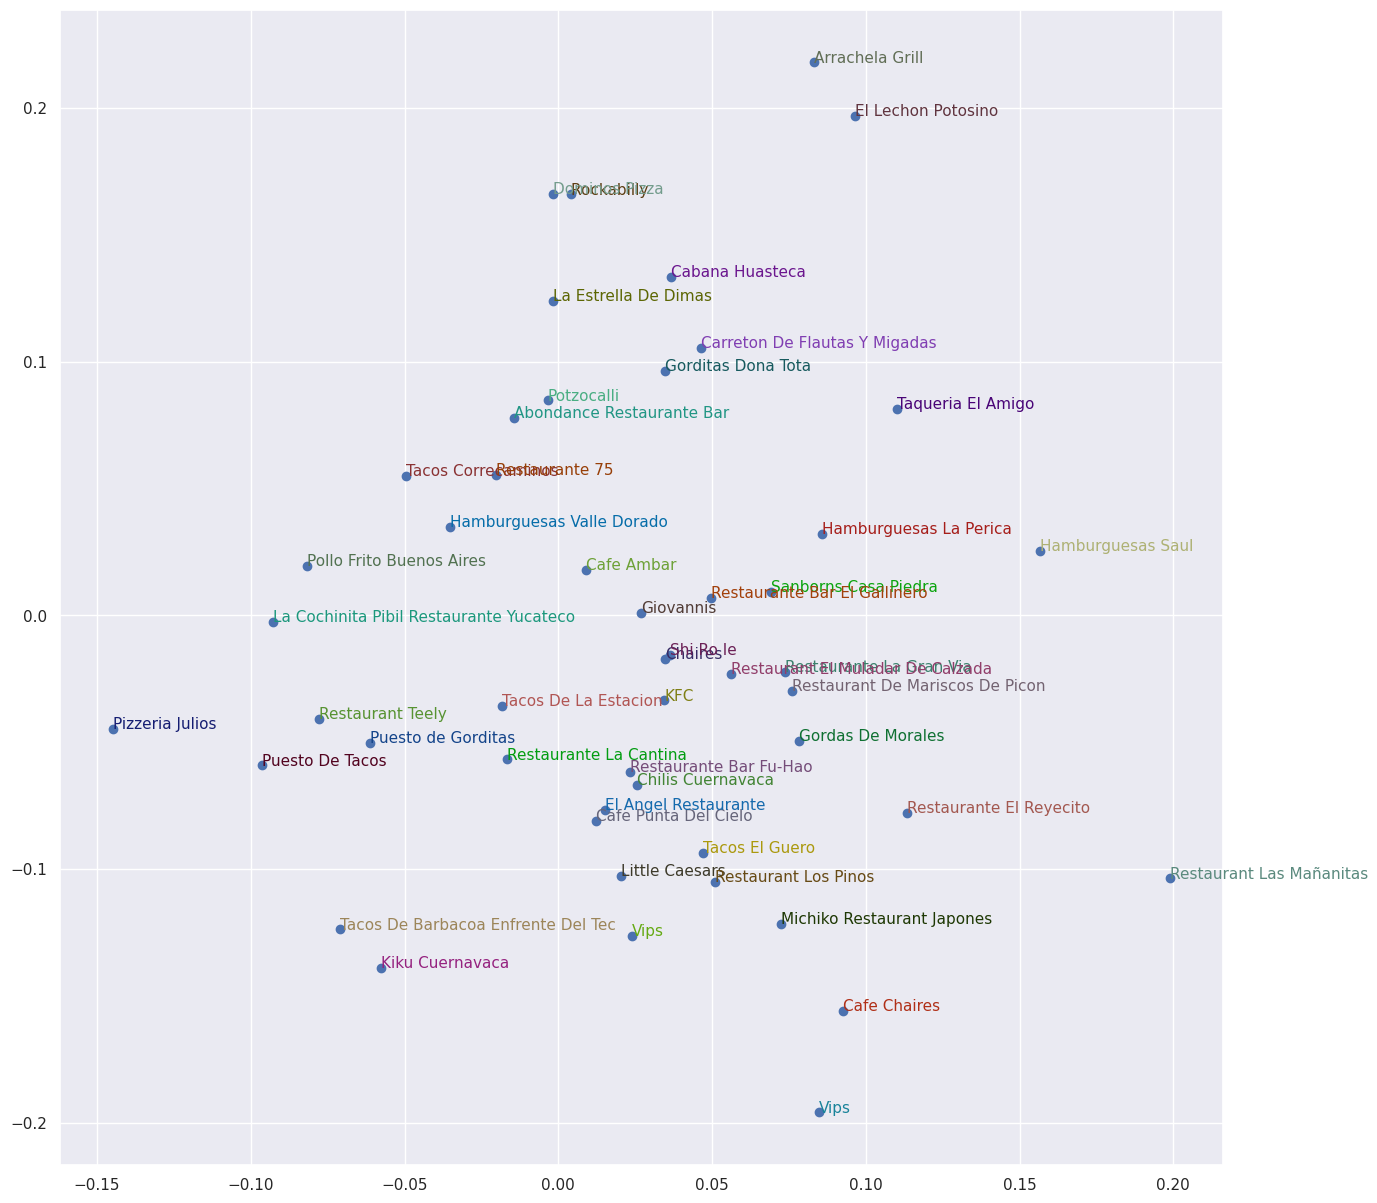

In [ ]:
#Lets map out our components:
idxs = np.random.choice(len(topRestaurants), 50, replace=False)
X = fac0[idxs]
Y = fac1[idxs]
plt.figure(figsize=(15,15))
plt.scatter(X,Y)
for i, x, y in zip(topRestaurants[idxs], X, Y):
    plt.text(x,y,restaurant_names[i],color=np.random.rand(3)*0.7, fontsize=11)
plt.show()

Here we are going to build our own NN to process inputs and compute activations. The PyTorch module is derived from nn.Module which will contain a function called forward to compute the forward pass.

In [ ]:
class DotProduct(nn.Module):
    def forward(self, u, m): return (u*m).sum(1)

In [ ]:
model=DotProduct()

In [ ]:
model(a,b)

tensor([ 6., 70.])

We need to fix some of the data to make it sequential and contiguous IDs.

In [ ]:
unique_users = Ratings.Consumer_ID.unique()
user_to_idx = {o:i for i,o in enumerate(unique_users)}
Ratings.Consumer_ID = Ratings.Consumer_ID.apply(lambda x:user_to_idx[x])

In [ ]:
unique_places = Ratings.Restaurant_ID.unique()
place_to_idx = {o:i for i,o in enumerate(unique_places)}
Ratings.placeID = Ratings.Restaurant_ID.apply(lambda x:place_to_idx[x])

In [ ]:
n_users=int(Ratings.Consumer_ID.nunique())
n_places=int(Ratings.Restaurant_ID.nunique())

Creating the module
We will create a module that looks up the factors for the users and places from the embedding matrix and then take the dot product.

in EmbeddingDot we create embedding matrices for users and restuarants, then they are initialized. With the forward pass we take categorical and contiuous variables.

In [ ]:
class EmbeddingDot(nn.Module):
    def __init__(self, n_users, n_places):
        super().__init__()
        self.u = nn.Embedding(n_users, n_factors)
        self.m = nn.Embedding(n_places, n_factors)
        self.u.weight.data.uniform_(0,0.05)
        self.m.weight.data.uniform_(0,0.05)

    def forward(self, cats, const):
        users,places = cats[:,0],cats[:,1]
        u,m = self.u(users),self.m(places)
        return (u*m).sum(1).view(-1,1)

We set up our crosstab where x is everything besides the rating , while y is the rating.

In [ ]:
x = Ratings.drop(['Overall_Rating'],axis=1)
y = Ratings['Overall_Rating'].astype(np.float32)

In [ ]:
Ratings['Overall_Rating'] = Ratings['Overall_Rating'].astype(float)


We can start settung up our model:

In [ ]:
Ratings['Consumer_ID'] = Ratings.Consumer_ID.apply(lambda x: x.replace('U',''))


In [ ]:
import torch
from torch import nn
from fastai.tabular.all import *
from fastai.vision.all import *




In [ ]:
dls = CollabDataLoaders.from_df(Ratings,
                                  valid_idx=val_idxs,
                                  user_name='Consumer_ID',
                                  item_name='Restaurant_ID',
                                  rating_name='Overall_Rating',
                                  bs=64)


In [ ]:
wd=1e-5
model = EmbeddingDot(n_users, n_places).cuda()
opt = SGD(model.parameters(), lr=1e-1, wd=wd, mom=0.9)


In [ ]:
learn = Learner(dls, model, loss_func=F.mse_loss, opt_func=optim.SGD)
fit(model, data, 3, opt, F.mse_loss)


NameError: name 'Learner' is not defined